In [1]:
import pandas as pd
import numpy as np

import re
import pycld2 as cld2
import nltk
import pickle

from textblob import TextBlob
from langdetect import detect
import matplotlib.pyplot as plt
from collections import Counter

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

In [2]:
trump_tweets = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n')
biden_tweets = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n')

In [3]:
#mark the tweets with their respective candidat and concat them in a new df containing all tweets
trump_tweets ['candidat'] = 'TRUMP'
biden_tweets ['candidat'] = 'BIDEN'
all_tweets = pd.concat([trump_tweets,biden_tweets])

# 1. Exploratory Data Analysis

In [4]:
all_tweets.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,candidat
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,TRUMP
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,TRUMP
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,TRUMP
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,TRUMP
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,TRUMP


In [5]:
all_tweets.count()

created_at              1747805
tweet_id                1747805
tweet                   1747805
likes                   1747805
retweet_count           1747805
source                  1746216
user_id                 1747805
user_name               1747771
user_screen_name        1747805
user_description        1564533
user_join_date          1747805
user_followers_count    1747805
user_location           1219061
lat                      801012
long                     801012
city                     414059
country                  796527
continent                796562
state                    580815
state_code               545034
collected_at            1747805
candidat                1747805
dtype: int64

In [6]:
# delete unnecessary columns
trump_tweets = trump_tweets.drop(columns = ['user_join_date','user_followers_count','likes','retweet_count','source','user_description','user_location','collected_at','lat','long'])
biden_tweets = biden_tweets.drop(columns = ['user_join_date','user_followers_count','likes','retweet_count','source','user_description','user_location','collected_at','lat','long'])
all_tweets = all_tweets.drop(columns = ['user_join_date','user_followers_count','likes','retweet_count','source','user_description','user_location','collected_at','lat','long'])

In [7]:
trump_tweets_nd = trump_tweets.drop_duplicates(subset='user_id', keep='last')
biden_tweets_nd = biden_tweets.drop_duplicates(subset='user_id', keep='last')

n = trump_tweets['tweet'].count()
t = trump_tweets_nd['tweet'].count()

k = biden_tweets['tweet'].count()
h = biden_tweets_nd['tweet'].count()

print('Total Number of TRUMP Tweets:',n,'\n')
print('Number of tweets - one tweet per person:',t)
print('\n-----------------------------------\n')
print('Total Number of BIDEN Tweets:',k,'\n')
print('Number of tweets - one tweet per person:',h)

Total Number of TRUMP Tweets: 970919 

Number of tweets - one tweet per person: 301378

-----------------------------------

Total Number of BIDEN Tweets: 776886 

Number of tweets - one tweet per person: 316073


## Top 10 tweeting countries

In [8]:
trump_tweets['country'].replace({'United States': 'United States of America'}, inplace=True)
biden_tweets['country'].replace({'United States': 'United States of America'}, inplace=True)
all_tweets['country'].replace({'United States': 'United States of America'}, inplace=True)

In [9]:
# fill the country column if there is no entry
all_tweets['country'] = all_tweets['country'].fillna('Geo Data NA')
trump_tweets['country'] = trump_tweets['country'].fillna('Geo Data NA')
biden_tweets['country'] = biden_tweets['country'].fillna('Geo Data NA')

all_tweets_nd = all_tweets.drop_duplicates(subset="tweet_id")

n = all_tweets_nd['country'].value_counts().head(10)
t = len(pd.unique(all_tweets_nd['country']))

k = trump_tweets['country'].value_counts().head(10)
h = len(pd.unique(trump_tweets['country']))

g = biden_tweets['country'].value_counts().head(10)
f = len(pd.unique(biden_tweets['country']))

print('Top ten countries all tweets:\n\n',n)
print('\n Number of different countries:',t)
print('\n-----------------------------------\n')
print('Top ten countries Trump tweets:\n\n',k)
print('\n Number of different countries:',h)
print('\n-----------------------------------\n')
print('Top ten countries Biden tweets:\n\n',g)
print('\n Number of different countries:',f)

Top ten countries all tweets:

 Geo Data NA                 829867
United States of America    356479
United Kingdom               50854
India                        31759
Germany                      29657
France                       27961
Canada                       24913
Italy                        16622
Australia                    13399
Mexico                        8667
Name: country, dtype: int64

 Number of different countries: 189

-----------------------------------

Top ten countries Trump tweets:

 Geo Data NA                 528171
United States of America    213263
United Kingdom               34743
Germany                      22618
France                       20689
India                        18559
Canada                       16996
Italy                        11206
Australia                     9365
Mexico                        5811
Name: country, dtype: int64

 Number of different countries: 185

-----------------------------------

Top ten countries Biden twee

<AxesSubplot:>

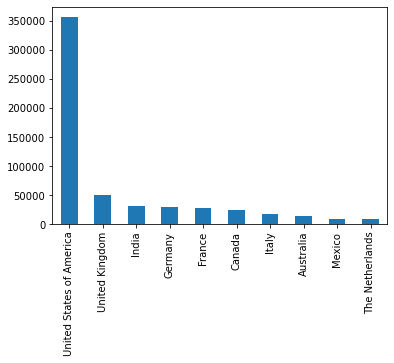

In [10]:
all_tweets_nd.loc[all_tweets_nd.country != 'Geo Data NA']['country'].value_counts().head(10).plot(kind='bar')

#### insert barplot of top five countries trump/biden

In [52]:
n = all_tweets['tweet'].count()
t = all_tweets['candidat'].value_counts()
k = len(pd.unique(all_tweets['user_id']))

b = all_tweets[all_tweets.candidat == 'TRUMP']
h = len(pd.unique(b['user_id']))

a = all_tweets[all_tweets.candidat == 'BIDEN']
g = len(pd.unique(a['user_id']))

f = all_tweets['user_name'].value_counts().head(10)

print('Number of Tweets from the US:',n,'\n')
print('Number of Tweets for each candidat:\n',t,'\n')
print('Unique Trump Users:',h,'\n')
print('Unique Biden Users:',g,'\n')
print('Unique Users in the whole Dataset:',k,'\n')

Number of Tweets from the US: 1747805 

Number of Tweets for each candidat:
 TRUMP    970919
BIDEN    776886
Name: candidat, dtype: int64 

Unique Trump Users: 301378 

Unique Biden Users: 316073 

Unique Users in the whole Dataset: 483212 



## Top 10 tweeting users

In [11]:
n = all_tweets_nd['user_name'].value_counts().head(10)
t = len(pd.unique(all_tweets_nd['user_id']))

k = trump_tweets['user_name'].value_counts().head(10)
h = len(pd.unique(trump_tweets['user_id']))

g = biden_tweets['user_name'].value_counts().head(10)
f = len(pd.unique(biden_tweets['user_id']))

print('Top ten users all tweets :\n\n',n)
print('\n Number of different users:',t)
print('\n-----------------------------------\n')
print('Top ten users Trump tweets:\n\n',k)
print('\n Number of different users:',h)
print('\n-----------------------------------\n')
print('Top ten users Biden tweets:\n\n',g)
print('\n Number of different users:',f)

Top ten users all tweets :

 Revue2presse                    1352
Global News Report              1325
VOTE BLUE Steve Ziegenbusch👑    1259
t Logan                         1232
Jonathan Greenberg              1076
yojo                             985
Scott McLeod (he, him, his)      980
Hotpage News                     927
THCPetDoctor                     913
TheCupofJoeintheD                901
Name: user_name, dtype: int64

 Number of different users: 483193

-----------------------------------

Top ten users Trump tweets:

 Revue2presse                                          1352
Global News Report                                    1325
Scott McLeod (he, him, his)                            980
t Logan                                                964
Hotpage News                                           921
THCPetDoctor                                           913
TheCupofJoeintheD                                      901
Maureen Devlin                                        

<AxesSubplot:>

/home/andyman/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/andyman/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0, flags=flags)


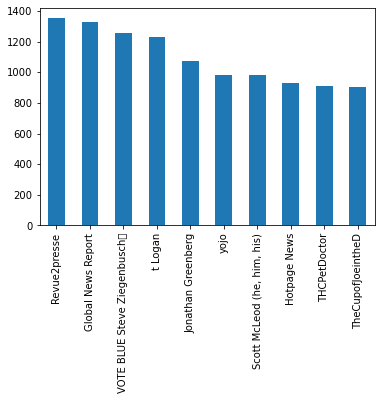

In [12]:
all_tweets_nd['user_name'].value_counts().head(10).plot(kind='bar')

## US tweets statistics

In [13]:
us_tweets = all_tweets[all_tweets.country == 'United States of America']
us_tweets_nd = us_tweets.drop_duplicates(subset="tweet_id", keep='first')

n = us_tweets_nd['tweet'].count()
t = len(pd.unique(us_tweets_nd['user_id']))
k = us_tweets_nd['user_name'].value_counts().head(10)
h = us_tweets_nd['state'].value_counts()
g = us_tweets_nd['city'].value_counts().head(15)

print('Number of Tweets from the US:',n,'\n')
print('Number of unique Users:',t,'\n')
print('Top ten US Users:\n',k,'\n')
print('Tweets per State:\n',h,'\n')
print('Tweets per City:\n',g,'\n')

Number of Tweets from the US: 356495 

Number of unique Users: 86964 

Top ten US Users:
 VOTE BLUE Steve Ziegenbusch👑                          1259
Jonathan Greenberg                                    1076
Scott McLeod (he, him, his)                            980
Hotpage News                                           927
THCPetDoctor                                           913
Maureen Devlin                                         856
Starbright489 #OnePersonOneVote #DoWillOfThePeople     794
Presidential News Network                              709
KD Webster                                             656
snarke                                                 593
Name: user_name, dtype: int64 

Tweets per State:
 California                  51767
New York                    39242
Texas                       27728
Florida                     27176
District of Columbia        14618
Pennsylvania                11279
Illinois                    11127
New Jersey                   82

In [14]:
us_tweets = us_tweets.drop_duplicates(subset="tweet_id", keep=False)

n = us_tweets['tweet'].count()
t = us_tweets['candidat'].value_counts()
k = len(pd.unique(us_tweets['user_id']))

b = us_tweets[us_tweets.candidat == 'TRUMP']
h = len(pd.unique(b['user_id']))

a = us_tweets[us_tweets.candidat == 'BIDEN']
g = len(pd.unique(a['user_id']))

f = us_tweets['user_name'].value_counts().head(10)

print('Number of Tweets from the US:',n,'\n')
print('Number of Tweets for each candidat:\n',t,'\n')
print('Unique Trump Users:',h,'\n')
print('Unique Biden Users:',g,'\n')
print('Unique Users in the whole Dataset:',k,'\n')
print('Top ten US Users:\n',f,'\n')

Number of Tweets from the US: 318720 

Number of Tweets for each candidat:
 TRUMP    175545
BIDEN    143175
Name: candidat, dtype: int64 

Unique Trump Users: 41131 

Unique Biden Users: 53562 

Unique Users in the whole Dataset: 81479 

Top ten US Users:
 VOTE BLUE Steve Ziegenbusch👑                          1259
Jonathan Greenberg                                    1070
Scott McLeod (he, him, his)                            980
THCPetDoctor                                           913
Maureen Devlin                                         850
Starbright489 #OnePersonOneVote #DoWillOfThePeople     737
Presidential News Network                              709
snarke                                                 549
joshua epstein🏳️‍🌈🖖🏼🗽👨🏼‍💻🇺🇸                            529
PulpNews Crime                                         523
Name: user_name, dtype: int64 



## Voter tweets

In [ ]:
# create a new file with the unique user ids from the us_tweets df

#trump_tweeters=b.drop_duplicates(subset="user_id", keep='last')
#biden_tweeters=a.drop_duplicates(subset="user_id", keep='last')

#uniqe_tweeters = pd.concat([trump_tweeters,biden_tweeters])
#uniqe_tweeters.to_csv('us_tweets_unique.csv')

At this point i switched to openrefine. I loaded the 'us_tweets_unique.csv' file and created a new project.

The goal was to obtain one tweet per person to get a df containing all the voters. The problem is that i have 13214 users with a tweet in both datasets. This is indicated by the number of unique users for Trump/Biden and the whole dataset.

Unique Trump Users: 41131 + Unique Biden Users: 53562 = 94693

Unique Users in the whole Dataset: 81479

94693 - 81479 = 13214

However if i just do drop.duplicates it would delete them only from Trump because his tweets are first in the us_tweets df. To balance this i need to remove 6607 tweets from each candidat respectivly.

The steps that i took in openrefine were:
1. Get all the duplicate user_id entires
2. Delete the other rows - that left me with 26428 rows
3. Reorder the rows - sort by: user_id ascending
4. Now i got a file with all the tweets from users that have a tweet for Trump and Biden
5. Split Trump and Biden Tweets (each file has exactly 13214 rows and is orderd the same way: so user 1 is the first entry in both data sets)

Now i have two files, each containing tweets for Trump and Biden from the same users.

In [15]:
# load the file and get the first 6607 entries
el_Tr = pd.read_csv('us_tweets-X_TRUMP.csv', lineterminator='\n',  encoding='latin-1')
el_Tr = el_Tr[:6607]

# drop the duplicate user_id's and keep the last one
b = b.drop_duplicates(subset='user_id',keep='last')
n=(len(pd.unique(b['user_id'])))

# concat the two df's and drop all duplicates of the user id's and keep none
tr_temp = pd.concat([el_Tr,b])
tr_temp = tr_temp.drop_duplicates(subset="user_id", keep= False)
t=(len(pd.unique(tr_temp['user_id'])))

print('Unique Trump Tweets before removal:',n,'\n')
print('Unique Trump Users after removal:',t,'\n')

Unique Trump Tweets before removal: 41131 

Unique Trump Users after removal: 34524 



In [16]:
# load the file and get the last 6607 entries
el_B = pd.read_csv('us_tweets-X_BIDEN.csv', lineterminator='\n',  encoding='latin-1')
el_B = el_B[-6607:]

# drop the duplicate user_id's and keep the last one
a = a.drop_duplicates(subset='user_id',keep='last')
n=(len(pd.unique(a['user_id'])))

# concat the two df's and drop all duplicates of the user id's and keep none
b_temp = pd.concat([el_B,a])
b_temp = b_temp.drop_duplicates(subset="user_id", keep=False)
t=(len(pd.unique(b_temp['user_id'])))

print('Unique Biden Tweets before removal:',n,'\n')
print('Unique Biden Users after removal:',t,'\n')

Unique Biden Tweets before removal: 53562 

Unique Biden Users after removal: 46955 



In [17]:
voter_tweets = pd.concat([tr_temp,b_temp])

# columns introduced from the 'us_tweets-X_TRUMP.csv' and 'us_tweets-X_BIDEN.csv' files but contain no values
voter_tweets = voter_tweets.drop(columns = ['Column','lat','long'])

n = len(pd.unique(voter_tweets['user_id']))
t = voter_tweets.count()
k = voter_tweets['candidat'].value_counts()
h = voter_tweets['state'].value_counts()
g = voter_tweets['city'].value_counts().head(10)

print('Number of Voters:',n,'\n')
print('Data Count:\n',t,'\n')
print('Number of Tweets for each candidat:\n',k,'\n')
print('Tweets per State:\n',h,'\n')
print('Tweets per City:\n',g,'\n')

Number of Voters: 81479 

Data Count:
 created_at          81479
tweet_id            81479
tweet               81479
user_id             81479
user_name           81478
city                43077
country             81479
continent           81479
state               71479
candidat            81479
user_screen_name    81479
state_code          71479
dtype: int64 

Number of Tweets for each candidat:
 BIDEN    46955
TRUMP    34524
Name: candidat, dtype: int64 

Tweets per State:
 California                  12288
New York                     8493
Texas                        7107
Florida                      5737
Illinois                     2857
Pennsylvania                 2493
District of Columbia         2448
Ohio                         1745
Massachusetts                1710
New Jersey                   1680
North Carolina               1676
Georgia                      1590
Arizona                      1576
Michigan                     1539
Colorado                     1317
Washing

## Common users & tweets

The common_users df consists of tweets from users that have a tweet in both datasets.

In [18]:
# get the common user id's from both data sets
common_uid=np.intersect1d(biden_tweets.user_id, trump_tweets.user_id)

# create data frames with users that only tweeted about trump or biden
unique_users_t = trump_tweets[~trump_tweets.user_id.isin(common_uid)].copy()
unique_users_b = biden_tweets[~biden_tweets.user_id.isin(common_uid)].copy()

# create data frame with users that tweeted about trump and biden
common_users_b = biden_tweets[biden_tweets.user_id.isin(common_uid)].copy()
common_users_t = trump_tweets[trump_tweets.user_id.isin(common_uid)].copy()

common_users = pd.concat([common_users_b,common_users_t])
common_users = common_users.drop_duplicates(subset='tweet_id')

unique_users = pd.concat([unique_users_t,unique_users_b])
unique_users = unique_users.drop_duplicates(subset='tweet_id')

n = common_users.count()
t = unique_users.count()

print('Common users:\n',n,'\n')
print('Unique users:\n',t,'\n')

Common users:
 created_at          937838
tweet_id            937838
tweet               937838
user_id             937838
user_name           937820
user_screen_name    937838
city                230047
country             937838
continent           450364
state               327731
state_code          308341
candidat            937838
dtype: int64 

Unique users:
 created_at          585091
tweet_id            585091
tweet               585091
user_id             585091
user_name           585076
user_screen_name    585091
city                127383
country             585091
continent           242715
state               182201
state_code          171978
candidat            585091
dtype: int64 



In [19]:
# get the common tweet id's from both data sets
common_tid = np.intersect1d(biden_tweets.tweet_id, trump_tweets.tweet_id)

# create data frame with users that used both hashtags
common_twb = biden_tweets[biden_tweets.tweet_id.isin(common_tid)].copy()
common_twt = trump_tweets[trump_tweets.tweet_id.isin(common_tid)].copy()

common_tweets = pd.concat([common_twb,common_twt])
common_tweets = common_tweets.drop_duplicates(subset='tweet_id')
common_tweets.count()

created_at          221700
tweet_id            221700
tweet               221700
user_id             221700
user_name           221699
user_screen_name    221700
city                 56031
country             221700
continent           102052
state                70069
state_code           63953
candidat            221700
dtype: int64

# 2. Data Preprocessing

In [20]:
# replace common contractions and abbreviations
def repl_contract(text):
    
    text = text.lower()
    cont = {
        "aren't" : 'are not',
        "can't" : 'cannot',
        "couldn't" : 'could not',
        "don't" : "do not",
        "didn't" : 'did not',
        "doesn't" : 'does not',
        "hadn't" : 'had not',
        "haven't" : 'have not',
        "hasn't" : "has not",
        "how's" : "how is",
        "he's" : 'he is',
        "she's" : 'she is',
        "he'll" : "he will",        
        "she'll" : 'she will',
        "he'd" : "he would",
        "she'd" : "she would",
        "here's" : "here is", 
        "i'm" : 'i am',
        "i've" : "i have",
        "i'll" : "i will",
        "i'd" : "i would",
        "isn't": "is not", 
        "it's" : "it is",
        "it'll" : "it will",
        "mustn't" : "must not",
        "shouldn't" : "should not",
        "that's" : "that is", 
        "there's" : "there is",
        "they're" : "they are",
        "they've" : "they have",
        "they'll" : "they will",
        "they'd" : "they would",
        "wasn't" : "was not",
        "we're" : "we are",
        "we've" : "we have",
        "we'll" : "we will", 
        "we'd" : "we would",
        "weren't" : "were not",
        "what's" : "what is",
        "when's" : "when is",
        "why's" : "why is",
        "where's" : "where is",
        "who's" : "who is",
        "who'll" : "who will",
        "won't" : "will not",
        "wouldn't" : "would not",
        "you're" : "you are",
        "you've" : "you have",
        "you'll" : "you will",
        "you'd" : "you would",
        "mayn't" : "may not",
        "4" : "for",
        "2" : "to",
        "1" : "one",
        "u" : "you",
        "r" : "are",
        "amp" : "",
        "re" : "",
        "gimme" : "give me",
        "gonna" : "going to",
        "cause" : "because",
        "imma" : "i am going to",
        "wanna" : "want to",
        "gotta" : "got to",
        "woulda" : "would have",
        "coulda" : "could have",
        "shoulda" : "should have",
        "let's" : "let us",
        "y'all" : "you all",
            }
    
    cleaned_text = []
    words = text.split()
    
    for word in words:
        if word in cont:
            cleaned_text.append(cont[word])
        else:
            cleaned_text.append(word)
    text = ' '.join(cleaned_text)
        
    return text

In [21]:
# clean the tweets
def clean(text):
    text = text.lower() # lower case
    text = re.sub(r"@[A-Za-z0-9]+","", text) # remove @mentions
    text = re.sub(r"#","", text) # remove #
    text = re.sub(r"\ART[\s]+","", text) # remove RT
    text = re.sub(r"https?:\/\/\S+","", text) # remove hyperlink
    text = re.sub("(.)\\1{2,}","\\1", text) # remove more than two characters.
    text = re.sub(r"[^A-Za-z0-9\s]+", " ",str(text)) #remove special characters
    
    return text

In [22]:
def detect_lang(tweet):
    try:
        isReliable, textBytesFound, details = cld2.detect(tweet)
        return details[0][0]
    except:
        return 'not found'

## All English tweets

In [ ]:
print('Replacing contractions...')
all_tweets['clean_tweet'] = all_tweets['tweet'].apply(repl_contract)
print('Cleaning tweets...')
all_tweets['clean_tweet'] = all_tweets['clean_tweet'].apply(clean)
print('Detecting language...')
all_tweets['language'] = all_tweets['clean_tweet'].apply(detect_lang)
print('Done')

In [ ]:
all_tweets['language'].value_counts().head(10)

In [ ]:
all_tweets['language'].replace({'SCOTS': 'ENGLISH'}, inplace=True)
all_tweets_eng = all_tweets[all_tweets['language'] == 'ENGLISH']
all_tweets_eng = all_tweets_eng.drop_duplicates(subset='tweet_id', keep=False)

## US Tweets

In [23]:
print('Replacing contractions...')
us_tweets['clean_tweet'] = us_tweets['tweet'].apply(repl_contract)
print('Cleaning tweets...')
us_tweets['clean_tweet'] = us_tweets['clean_tweet'].apply(clean)
print('Detecting language...')
us_tweets['language'] = us_tweets['clean_tweet'].apply(detect_lang)
print('Done')

Replacing contractions...
Cleaning tweets...
Detecting language...
Done


In [24]:
us_tweets['language'].value_counts().head(10)

ENGLISH       278587
Unknown        30937
SPANISH         3332
BASQUE          2979
SCOTS            917
FRENCH           637
GERMAN           378
ITALIAN          348
PORTUGUESE       103
TURKISH           99
Name: language, dtype: int64

In [25]:
us_tweets['language'].replace({'SCOTS': 'ENGLISH'}, inplace=True)
us_tweets_eng = us_tweets[us_tweets['language'] == 'ENGLISH']
us_tweets_eng = us_tweets_eng.drop_duplicates(subset='tweet_id', keep=False)

## Voter tweets

In [26]:
print('Replacing contractions...')
voter_tweets['clean_tweet'] = voter_tweets['tweet'].apply(repl_contract)
print('Cleaning tweets...')
voter_tweets['clean_tweet'] = voter_tweets['clean_tweet'].apply(clean)
print('Detecting language...')
voter_tweets['language'] = voter_tweets['clean_tweet'].apply(detect_lang)
print('Done')

Replacing contractions...
Cleaning tweets...
Detecting language...
Done


In [27]:
voter_tweets['language'].value_counts().head(10)

ENGLISH       69727
Unknown        9279
BASQUE         1106
SPANISH         639
SCOTS           263
FRENCH           90
GERMAN           78
PORTUGUESE       56
ITALIAN          49
TURKISH          47
Name: language, dtype: int64

In [28]:
voter_tweets['language'].replace({'SCOTS': 'ENGLISH'}, inplace=True)
voter_tweets = voter_tweets[voter_tweets['language'] == 'ENGLISH']

n = voter_tweets['tweet'].count()
t = voter_tweets['candidat'].value_counts()

print('Number of Tweets:',n,'\n')
print('Number of Tweets for each candidat:\n',t)

Number of Tweets: 69990 

Number of Tweets for each candidat:
 BIDEN    39655
TRUMP    30335
Name: candidat, dtype: int64


In [30]:
n = voter_tweets['tweet'].count()
t = voter_tweets['candidat'].value_counts()
k = len(pd.unique(voter_tweets['user_id']))

b = voter_tweets[voter_tweets.candidat == 'TRUMP']
h = len(pd.unique(b['user_id']))

a = voter_tweets[voter_tweets.candidat == 'BIDEN']
g = len(pd.unique(a['user_id']))

f = voter_tweets['user_name'].value_counts().head(10)

print('Number of Voter Tweets:',n,'\n')
print('Number of Tweets for each candidat:\n',t,'\n')
print('Unique Trump Users:',h,'\n')
print('Unique Biden Users:',g,'\n')
print('Unique Users in the whole Dataset:',k,'\n')

Number of Voter Tweets: 69990 

Number of Tweets for each candidat:
 BIDEN    39655
TRUMP    30335
Name: candidat, dtype: int64 

Unique Trump Users: 30335 

Unique Biden Users: 39655 

Unique Users in the whole Dataset: 69990 



In [31]:
voter_tweets.head()

,created_at,tweet_id,tweet,user_id,user_name,city,country,continent,state,candidat,user_screen_name,state_code,clean_tweet,language
7,2020-10-15 00:00:18,1.316529e+18,@DeeviousDenise @realDonaldTrump @nypost There...,9.007611e+17,Stacey Gulledge 🇺🇸 Patriot ♥️ KAG 🙏 👮‍♀️♥️,NaN,United States of America,North America,Ohio,TRUMP,sm_gulledge,OH,there won t be many of them unless you all h...,ENGLISH
29,2020-10-15 00:01:30,1.316530e+18,@karatblood @KazePlays_JC Grab @realDonaldTrum...,3.602439e+07,Baylee,Chicago,United States of America,North America,Illinois,TRUMP,bayleewashere,IL,jc grab by the balls amp chuck the bastar...,ENGLISH
75,2020-10-15 00:03:38,1.316530e+18,@JoeBiden #donaldtrump 4 more years!,1.657854e+07,Scott Seifferlein,Grand Rapids,United States of America,North America,Michigan,TRUMP,Seifferlein,MI,donaldtrump for more years,ENGLISH
92,2020-10-15 00:05:01,1.316530e+18,GOP TRIES TO STEAL THE ELECTION!!! Trump urges...,2.479320e+07,Paul Cline,NaN,United States of America,North America,Florida,TRUMP,paulcline7,FL,gop tries to steal the election trump urges c...,ENGLISH
99,2020-10-15 00:05:21,1.316531e+18,Good for @kayleighmcenany. Who knew that tryin...,2.902245e+09,Brian W. Peterson,Kansas City,United States of America,North America,Missouri,TRUMP,cybrpete,MO,good for who knew that trying to get out inf...,ENGLISH


In [ ]:
voter_tweets = voter_tweets.drop(columns= ['country','continent','language','tweet'])

## Tweets with both hashtags

In [32]:
print('Replacing contractions...')
common_users['clean_tweet'] = common_users['tweet'].apply(repl_contract)
print('Cleaning tweets...')
common_users['clean_tweet'] = common_users['clean_tweet'].apply(clean)
print('Detecting language...')
common_users['language'] = common_users['clean_tweet'].apply(detect_lang)
print('Done')

Replacing contractions...
Cleaning tweets...
Detecting language...
Done


In [33]:
print('Replacing contractions...')
common_tweets['clean_tweet'] = common_tweets['tweet'].apply(repl_contract)
print('Cleaning tweets...')
common_tweets['clean_tweet'] = common_tweets['clean_tweet'].apply(clean)
print('Detecting language...')
common_tweets['language'] = common_tweets['clean_tweet'].apply(detect_lang)
print('Done')

Replacing contractions...
Cleaning tweets...
Detecting language...
Done


In [34]:
n = common_users['language'].value_counts().head(10)
t = common_tweets['language'].value_counts().head(10)

print('Number of languages for common users:\n',n,'\n')
print('Number of languages for common tweets:\n',t,'\n')

Number of languages for common users:
 ENGLISH       660133
Unknown       112356
SPANISH        39166
GERMAN         33800
FRENCH         33339
ITALIAN        24643
DUTCH           8892
TURKISH         5506
BASQUE          5173
PORTUGUESE      3553
Name: language, dtype: int64 

Number of languages for common tweets:
 ENGLISH       139245
Unknown        31585
SPANISH        13856
FRENCH          9968
GERMAN          8749
ITALIAN         7178
TURKISH         2596
DUTCH           2555
PORTUGUESE      1514
POLISH           734
Name: language, dtype: int64 



In [35]:
common_users['language'].replace({'SCOTS': 'ENGLISH'}, inplace=True)
common_tweets['language'].replace({'SCOTS': 'ENGLISH'}, inplace=True)

common_users_eng = common_users[common_users['language'] == 'ENGLISH']
common_tweets_eng = common_tweets[common_tweets['language'] == 'ENGLISH']

# Sentiment Analysis

In [36]:
file = open('model_LR.pickle','rb')
model = pickle.load(file)
file.close()

In [37]:
def get_sentiment(model, data, level_of_significance):
    
    sentiments=[]
    polarity = []
    prediction_prob = model.predict_proba(data)

    for prob in prediction_prob:
        dif = prob[1] - prob[0]
        polarity.append(prob[1])
        if dif >= -level_of_significance and dif <= level_of_significance:
            sentiments.append('Neutral')
        elif dif > level_of_significance:
            sentiments.append('Positive')
        else:
            sentiments.append('Negative')
            
    return sentiments, polarity

In [38]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity
def get_analysis(score):
    if score < 0:
        return 'Negative'
    elif score==0:
        return 'Neutral'
    else:
        return 'Positive'

## Sentiment on all english tweets

In [ ]:
all_sentiment, all_polarity = get_sentiment(model, all_tweets_eng['clean_tweet'], 0.1)
all_tweets_eng['Sentiment'] = all_sentiment
all_tweets_eng['Polarity'] = all_polarity

In [ ]:
n = all_tweets_eng['tweet'].count()
t = all_tweets_eng['candidat'].value_counts()
k = all_tweets_eng['Sentiment'].value_counts()

print('Number of tweets:\n',n,'\n')
print('Tweets per candidat:\n',t,'\n')
print('Sentiments all tweets:\n',k,'\n')

## Sentiment on US tweets

In [39]:
us_sentiment, us_polarity = get_sentiment(model, us_tweets_eng['clean_tweet'], 0.1)
us_tweets_eng['Sentiment'] = us_sentiment
us_tweets_eng['Polarity'] = us_polarity

In [40]:
n = us_tweets_eng['tweet'].count()
t = us_tweets_eng['candidat'].value_counts()
k = us_tweets_eng['Sentiment'].value_counts()

print('Number of tweets:\n',n,'\n')
print('Tweets per candidat:\n',t,'\n')
print('Sentiments US tweets:\n',k,'\n')

Number of tweets:
 279504 

Tweets per candidat:
 TRUMP    158524
BIDEN    120980
Name: candidat, dtype: int64 

Sentiments US tweets:
 Positive    154872
Negative     91697
Neutral      32935
Name: Sentiment, dtype: int64 



In [41]:
us_B = us_tweets_eng[us_tweets_eng.candidat == 'BIDEN']
us_T = us_tweets_eng[us_tweets_eng.candidat == 'TRUMP']
n = us_B['Sentiment'].value_counts()
t = us_T['Sentiment'].value_counts()

print('US Sentiments Biden:\n',n,'\n')
print('US Sentiments Trump:\n',t,'\n')

US Sentiments Biden:
 Positive    73292
Negative    34086
Neutral     13602
Name: Sentiment, dtype: int64 

US Sentiments Trump:
 Positive    81580
Negative    57611
Neutral     19333
Name: Sentiment, dtype: int64 



In [42]:
n = us_tweets_eng['tweet'].count()
t = us_tweets_eng['candidat'].value_counts()
k = len(pd.unique(us_tweets_eng['user_id']))

b = us_tweets_eng[us_tweets_eng.candidat == 'TRUMP']
h = len(pd.unique(b['user_id']))

a = us_tweets_eng[us_tweets_eng.candidat == 'BIDEN']
g = len(pd.unique(a['user_id']))

f = us_tweets_eng['user_name'].value_counts().head(10)

print('Number of Tweets from the US:',n,'\n')
print('Number of Tweets for each candidat:\n',t,'\n')
print('Unique Trump Users:',h,'\n')
print('Unique Biden Users:',g,'\n')
print('Unique Users in the whole Dataset:',k,'\n')
print('Top ten US Users:\n',f,'\n')

Number of Tweets from the US: 279504 

Number of Tweets for each candidat:
 TRUMP    158524
BIDEN    120980
Name: candidat, dtype: int64 

Unique Trump Users: 37510 

Unique Biden Users: 47130 

Unique Users in the whole Dataset: 72994 

Top ten US Users:
 Jonathan Greenberg                                    1070
Scott McLeod (he, him, his)                            966
THCPetDoctor                                           911
Maureen Devlin                                         849
Starbright489 #OnePersonOneVote #DoWillOfThePeople     732
Presidential News Network                              704
VOTE BLUE Steve Ziegenbusch👑                           578
snarke                                                 549
joshua epstein🏳️‍🌈🖖🏼🗽👨🏼‍💻🇺🇸                            528
PulpNews Crime                                         522
Name: user_name, dtype: int64 



## Sentiment on common users & tweets

In [43]:
common_sentiment, common_polarity = get_sentiment(model, common_users_eng['clean_tweet'], 0.1)
common_users_eng['Sentiment'] = common_sentiment
common_users_eng['Polarity'] = common_polarity

<ipython-input-43-d056935acefd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_users_eng['Sentiment'] = common_sentiment
<ipython-input-43-d056935acefd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_users_eng['Polarity'] = common_polarity


In [44]:
common_sentiment, common_polarity = get_sentiment(model, common_tweets_eng['clean_tweet'], 0.1)
common_tweets_eng['Sentiment'] = common_sentiment
common_tweets_eng['Polarity'] = common_polarity

<ipython-input-44-1ee8f52ac208>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_tweets_eng['Sentiment'] = common_sentiment
<ipython-input-44-1ee8f52ac208>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_tweets_eng['Polarity'] = common_polarity


In [45]:
n = common_users_eng['Sentiment'].value_counts()
t = common_tweets_eng['Sentiment'].value_counts()

print('Sentiments common users:\n',n,'\n')
print('Sentiments common tweets:\n',t,'\n')

Sentiments common users:
 Positive    370614
Negative    210345
Neutral      81757
Name: Sentiment, dtype: int64 

Sentiments common tweets:
 Positive    89001
Negative    34155
Neutral     16625
Name: Sentiment, dtype: int64 



## Sentiment on voter tweets

In [46]:
voter_sentiment, voter_polarity = get_sentiment(model, voter_tweets['clean_tweet'], 0.1)
voter_tweets['Sentiment_ML'] = voter_sentiment
voter_tweets['Polarity_ML'] = voter_polarity

In [47]:
voter_tweets['Polarity_LX'] = voter_tweets['clean_tweet'].apply(get_polarity)
voter_tweets['Sentiment_LX'] = voter_tweets['Polarity_LX'].apply(get_analysis)

In [48]:
tweets_B = voter_tweets[voter_tweets.candidat == 'BIDEN']
tweets_T = voter_tweets[voter_tweets.candidat == 'TRUMP']

In [49]:
n = tweets_T['Sentiment_ML'].value_counts()
t = tweets_B['Sentiment_ML'].value_counts()

k = tweets_T['Sentiment_LX'].value_counts()
h = tweets_B['Sentiment_LX'].value_counts()

print('ML Sentiments Trump:\n',n,'\n')
print('ML Sentiments Biden:\n',t,'\n')
print('LX Sentiments Trump:\n',k,'\n')
print('LX Sentiments Biden:\n',h,'\n')

ML Sentiments Trump:
 Positive    16829
Negative     9973
Neutral      3533
Name: Sentiment_ML, dtype: int64 

ML Sentiments Biden:
 Positive    26003
Negative     9683
Neutral      3969
Name: Sentiment_ML, dtype: int64 

LX Sentiments Trump:
 Positive    11836
Neutral     11436
Negative     7063
Name: Sentiment_LX, dtype: int64 

LX Sentiments Biden:
 Positive    18160
Neutral     15093
Negative     6402
Name: Sentiment_LX, dtype: int64 



In [50]:
pos_biden = tweets_B[tweets_B['Sentiment_ML'] == 'Positive']
neg_biden = tweets_B[tweets_B['Sentiment_ML'] == 'Negative']

pos_trump = tweets_T[tweets_T['Sentiment_ML'] == 'Positive']
neg_trump = tweets_T[tweets_T['Sentiment_ML'] == 'Negative']

biden_results = pd.concat([pos_biden,neg_trump])
trump_results = pd.concat([neg_biden,pos_trump])

In [51]:
# get a sample of 30000 tweets for each candidat 
trump = voter_tweets.loc[voter_tweets['candidat'] == 'TRUMP']
biden = voter_tweets.loc[voter_tweets['candidat'] == 'BIDEN']

trump = trump.sample(n=30000)
biden = biden.sample(n=30000)

n = trump['Sentiment_ML'].value_counts()
t = biden['Sentiment_ML'].value_counts()

print('ML Sentiments Trump:\n',n,'\n')
print('ML Sentiments Biden:\n',t,'\n')

ML Sentiments Trump:
 Positive    16649
Negative     9853
Neutral      3498
Name: Sentiment_ML, dtype: int64 

ML Sentiments Biden:
 Positive    19701
Negative     7307
Neutral      2992
Name: Sentiment_ML, dtype: int64 



In [ ]:
us_tweets.count()

In [ ]:
us_tweets['state_code'] = us_tweets['state_code'].fillna('NA')
us_tweets['state'] = us_tweets['state'].fillna('NA')
us_tweets['city'] = us_tweets['city'].fillna('NA')

In [ ]:
#us_tweets.to_csv('us_tweets.csv')

In [ ]:
#import plotly
#import plotly.express as px
  
#fig = px.choropleth(us_tweets, locations = ' locationmode="USA-states", color=[1], scope="usa")
  
#fig.show()

In [ ]:
print("Trump vs Biden ML and LX")
plotdata = pd.DataFrame({
    "BIDEN_ML":[26003 ,3969, 9683],
    "BIDEN_LX":[18160 ,15093, 6402],
    "TRUMP_ML":[16829 ,3533, 9973], 
    "TRUMP":[11836 ,11436, 7063],        
    }, 
    index=["Positive", "Neutral", "Negative"]
)

plotdata.plot(kind="bar",figsize=(22,12),fontsize=25)
# Pad margins so that markers don't get c)
plt.title("",fontsize=25)
plt.xlabel("\n Sentiment",fontsize=25)
plt.xticks(rotation=0)

plt.legend(loc=1, fontsize = 'xx-large')

plt.ylabel("Count",fontsize=25)
plt.show()

In [ ]:
print("Trump vs Biden ML and LX")
plotdata = pd.DataFrame({
    "BIDEN_ML":[26003 ,3969, 9683],
    "BIDEN_SAMPLE":[19684 ,2990, 7326],
    "TRUMP_ML":[16829 ,3533, 9973], 
    "TRUMP_SAMPLE":[16638 ,3500, 9862],        
    }, 
    index=["Positive", "Neutral", "Negative"]
)

plotdata.plot(kind="bar",figsize=(22,12),fontsize=25)
# Pad margins so that markers don't get c)
plt.title("",fontsize=25)
plt.xlabel("\n Sentiment",fontsize=25)
plt.xticks(rotation=0)

plt.legend(loc=1, fontsize = 'xx-large')

plt.ylabel("Count",fontsize=25)
plt.show()